# Heart Disease Prediction - Model Explainability

This notebook focuses on model interpretability and explainability:
- Feature importance analysis
- SHAP (SHapley Additive exPlanations) values
- LIME (Local Interpretable Model-agnostic Explanations)
- Permutation importance
- Partial dependence plots


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance, partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import warnings
from pathlib import Path
import sys

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

# Load data directly
df = pd.read_csv('../data/raw/Heart_disease_cleveland_new.csv')
print(f"Dataset loaded: {df.shape}")

# Quick data check
print(f"Columns: {list(df.columns)}")
print(f"Target unique values: {sorted(df['target'].unique()) if 'target' in df.columns else 'No target column'}")

# Define features
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

available_numerical = [col for col in numerical_features if col in df.columns]
available_categorical = [col for col in categorical_features if col in df.columns]

print(f"Available numerical features: {available_numerical}")
print(f"Available categorical features: {available_categorical}")

# Simple preprocessing for explainability analysis
if 'target' in df.columns:
    feature_cols = available_numerical + available_categorical
    df_clean = df.dropna(subset=['target'])
    X = df_clean[feature_cols].fillna(df_clean[feature_cols].median())
    y = df_clean['target']
    
    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)
    
    # Scale numerical features
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    if available_numerical:
        X_train_scaled[available_numerical] = scaler.fit_transform(X_train[available_numerical])
        X_test_scaled[available_numerical] = scaler.transform(X_test[available_numerical])
    
    print(f"Training data: {X_train_scaled.shape}")
    print(f"Test data: {X_test_scaled.shape}")
else:
    print("❌ Target column not found! Cannot proceed with explainability analysis.")


Dataset loaded: (303, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
Target unique values: [np.int64(0), np.int64(1)]
Available numerical features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
Available categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
Training data: (181, 13)
Test data: (61, 13)


## 1. Train Models for Explainability Analysis


In [2]:
# Train models for explainability analysis
print("="*60)
print("====== Training Models for Explainability ======")
print("="*60)

if 'target' in df.columns:
    # Train models that support feature importance
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
        'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42)
    }

    trained_models = {}
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train_scaled, y_train)
        trained_models[name] = model
        print(f"✓ {name} trained successfully")

    # Create ensemble for comprehensive analysis
    from sklearn.ensemble import VotingClassifier
    ensemble_models = [(name, model) for name, model in trained_models.items()]
    ensemble = VotingClassifier(estimators=ensemble_models, voting='soft')
    ensemble.fit(X_train_scaled, y_train)
    trained_models['Ensemble'] = ensemble

    print(f"\n✅ All models trained successfully!")
    print(f"Models available: {list(trained_models.keys())}")
else:
    print("❌ Cannot train models - target column not found!")
    trained_models = {}


====== Training Models for Explainability ======
Training Random Forest...
✓ Random Forest trained successfully
Training Gradient Boosting...
✓ Gradient Boosting trained successfully
Training Decision Tree...
✓ Decision Tree trained successfully

✅ All models trained successfully!
Models available: ['Random Forest', 'Gradient Boosting', 'Decision Tree', 'Ensemble']


## 2. Feature Importance Analysis


======== Feature Importance Analysis ========


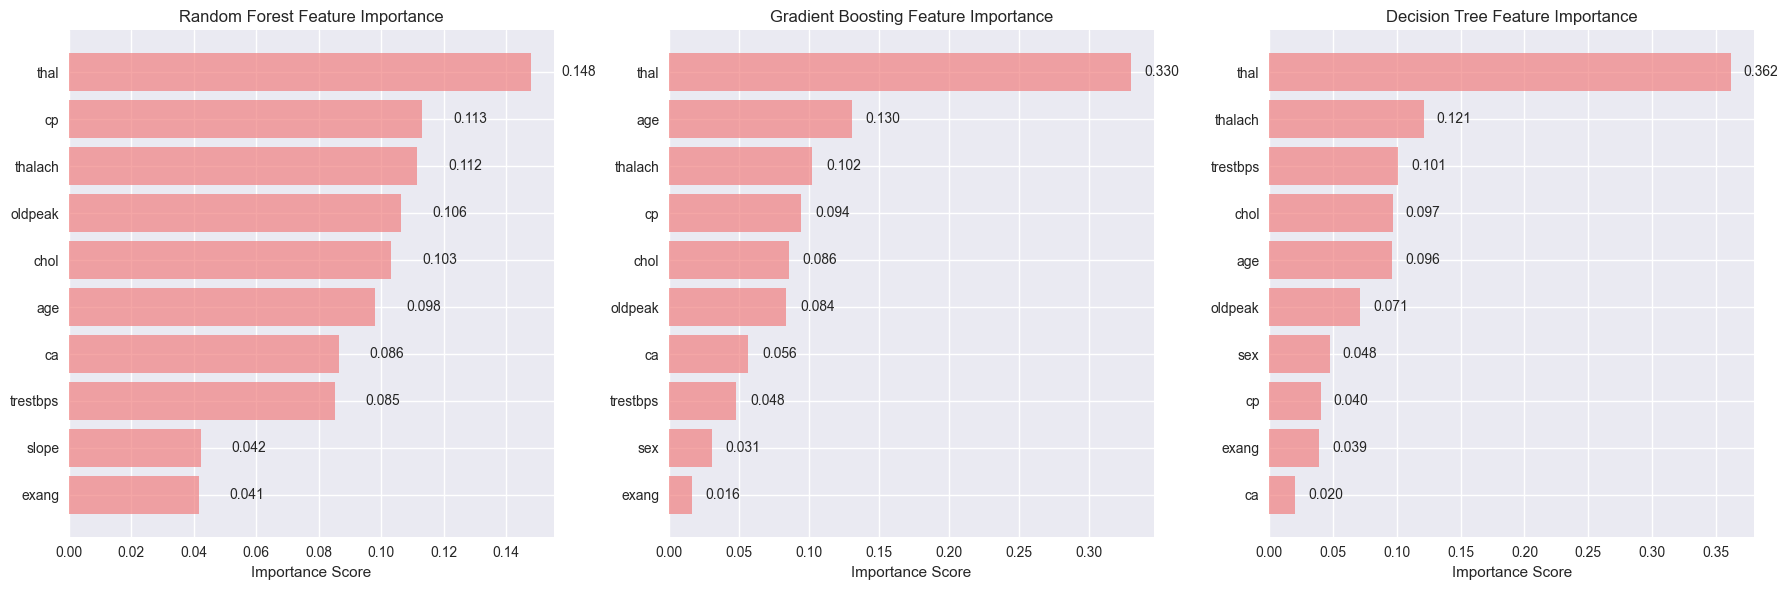


Top 5 Most Important Features by Model:

Random Forest:
  1. thal: 0.1479
  2. cp: 0.1132
  3. thalach: 0.1116
  4. oldpeak: 0.1064
  5. chol: 0.1031

Gradient Boosting:
  1. thal: 0.3297
  2. age: 0.1304
  3. thalach: 0.1024
  4. cp: 0.0943
  5. chol: 0.0855

Decision Tree:
  1. thal: 0.3618
  2. thalach: 0.1209
  3. trestbps: 0.1011
  4. chol: 0.0966
  5. age: 0.0963


In [3]:
# Feature importance analysis
print("="*60)
print("======== Feature Importance Analysis ========")
print("="*60)

if trained_models:
    # Get feature names
    feature_names = X_train_scaled.columns.tolist()

    # Plot feature importance for tree-based models
    tree_models = ['Random Forest', 'Gradient Boosting', 'Decision Tree']
    available_tree_models = [name for name in tree_models if name in trained_models]
    
    if available_tree_models:
        fig, axes = plt.subplots(1, len(available_tree_models), figsize=(6*len(available_tree_models), 6))
        if len(available_tree_models) == 1:
            axes = [axes]

        for i, model_name in enumerate(available_tree_models):
            model = trained_models[model_name]
            
            # Get feature importances
            importances = model.feature_importances_
            
            # Sort features by importance
            indices = np.argsort(importances)[::-1][:10]  # Top 10 features
            
            # Create plot
            bars = axes[i].barh(range(len(indices)), importances[indices], 
                               color='lightcoral', alpha=0.7)
            axes[i].set_yticks(range(len(indices)))
            axes[i].set_yticklabels([feature_names[idx] for idx in indices])
            axes[i].set_xlabel('Importance Score')
            axes[i].set_title(f'{model_name} Feature Importance')
            axes[i].invert_yaxis()
            
            # Add value labels
            for j, (bar, idx) in enumerate(zip(bars, indices)):
                axes[i].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                            f'{importances[idx]:.3f}', va='center')

        plt.tight_layout()
        plt.show()

        # Compare feature importance across models
        print("\nTop 5 Most Important Features by Model:")
        print("="*50)

        for model_name in available_tree_models:
            model = trained_models[model_name]
            importances = model.feature_importances_
            top_indices = np.argsort(importances)[::-1][:5]
            
            print(f"\n{model_name}:")
            for i, idx in enumerate(top_indices, 1):
                print(f"  {i}. {feature_names[idx]}: {importances[idx]:.4f}")
    else:
        print("❌ No tree-based models available for feature importance analysis")
else:
    print("❌ No models trained - cannot perform feature importance analysis")


## 3. Permutation Importance Analysis


Permutation Importance Analysis
Calculating permutation importance for Random Forest...
✓ Random Forest permutation importance calculated
Calculating permutation importance for Gradient Boosting...
✓ Gradient Boosting permutation importance calculated
Calculating permutation importance for Decision Tree...
✓ Decision Tree permutation importance calculated
Calculating permutation importance for Ensemble...
✓ Ensemble permutation importance calculated


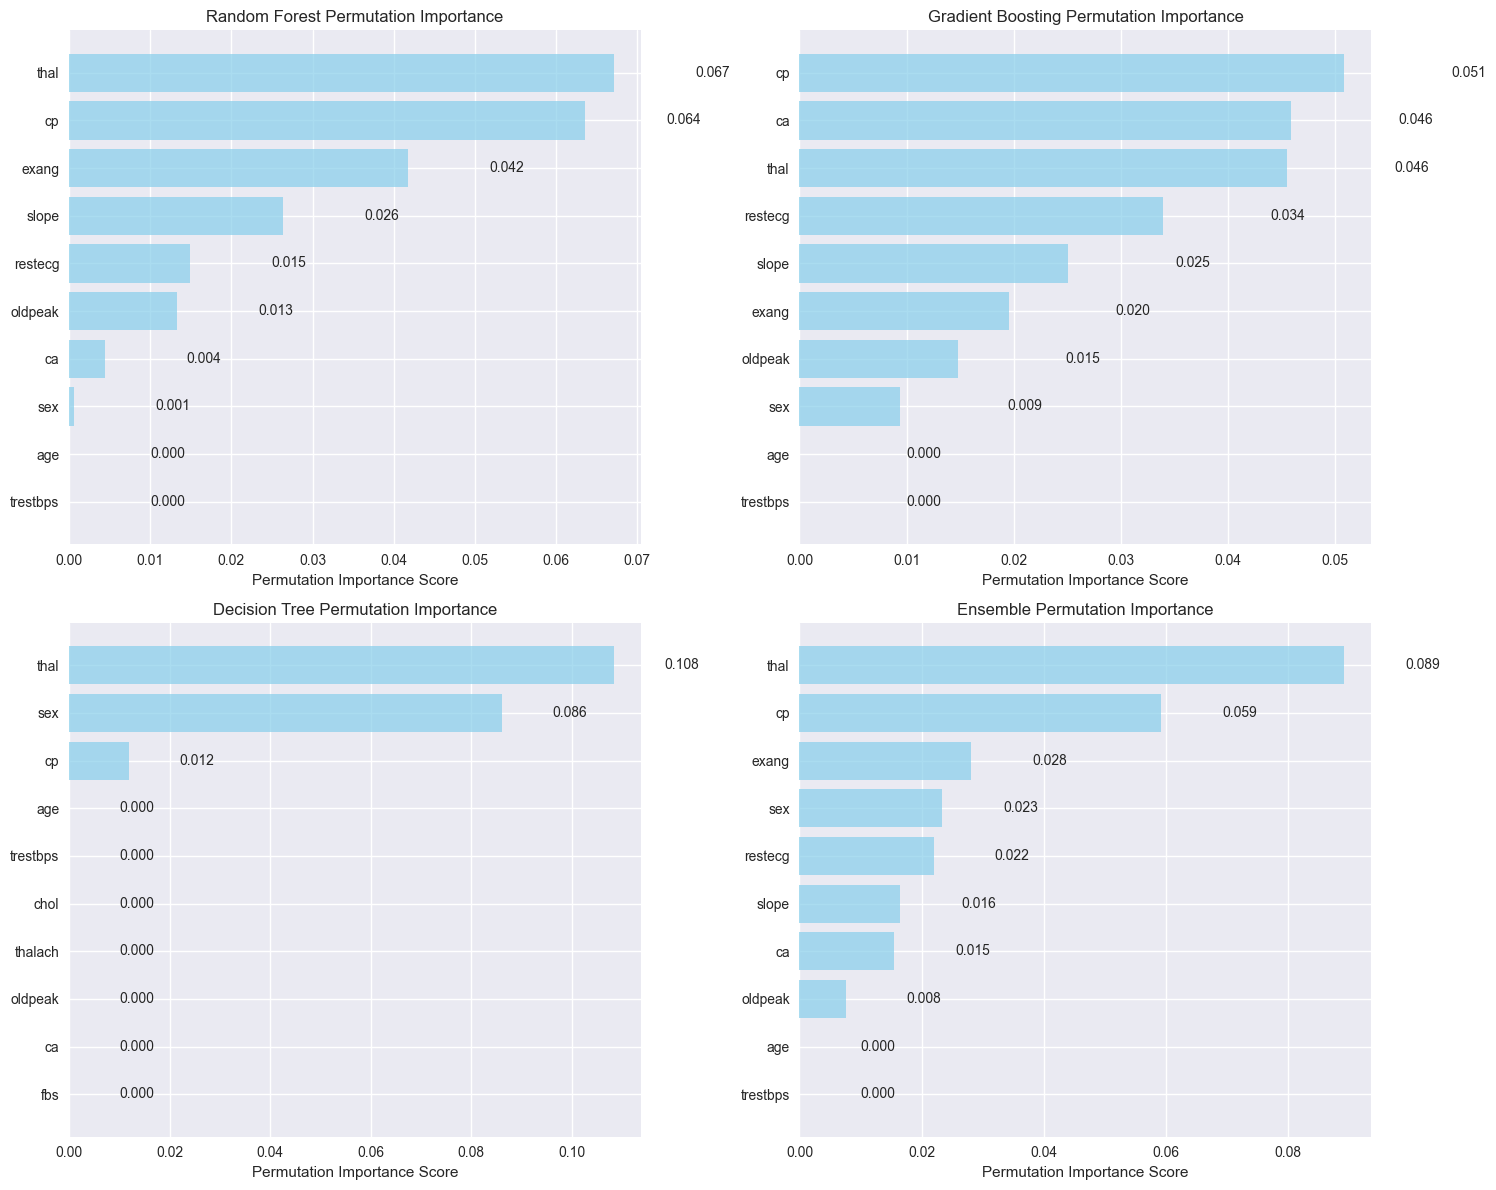


Most Important Features Across All Models:

Top Features by Average Rank:
 1. thal: 1.5
 2. cp: 2.0
 3. sex: 5.5
 4. exang: 6.0
 5. restecg: 6.2
 6. ca: 6.2
 7. slope: 7.0
 8. age: 7.8
 9. trestbps: 8.8


In [ ]:
# Permutation importance analysis
print("Permutation Importance Analysis")

# Calculate permutation importance for each model
perm_results = {}

for model_name, model in trained_models.items():
    print(f"Calculating permutation importance for {model_name}...")
    
    # Calculate permutation importance
    perm_importance = permutation_importance(
        model, X_test, y_test, 
        n_repeats=10, 
        random_state=42,
        scoring='roc_auc'
    )
    
    # Create importance dictionary
    importance_dict = {
        feature: score for feature, score in 
        zip(feature_names, perm_importance.importances_mean)
    }
    
    # Sort by importance
    importance_dict = dict(sorted(importance_dict.items(), 
                                key=lambda x: x[1], reverse=True))
    
    perm_results[model_name] = importance_dict
    
    print(f"✓ {model_name} permutation importance calculated")

# Visualize permutation importance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (model_name, importance_dict) in enumerate(perm_results.items()):
    if i < len(axes):
        # Get top 10 features
        top_features = list(importance_dict.items())[:10]
        features, scores = zip(*top_features)
        
        bars = axes[i].barh(range(len(features)), scores, color='skyblue', alpha=0.7)
        axes[i].set_yticks(range(len(features)))
        axes[i].set_yticklabels(features)
        axes[i].set_xlabel('Permutation Importance Score')
        axes[i].set_title(f'{model_name} Permutation Importance')
        axes[i].invert_yaxis()
        
        # Add value labels
        for j, (bar, score) in enumerate(zip(bars, scores)):
            axes[i].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                        f'{score:.3f}', va='center')

# Hide unused subplot
if len(perm_results) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Summary of most important features across all models
print("\nMost Important Features Across All Models:")
print("="*50)

all_features = set()
for importance_dict in perm_results.values():
    all_features.update(list(importance_dict.keys())[:5])

feature_ranks = {}
for feature in all_features:
    ranks = []
    for importance_dict in perm_results.values():
        if feature in importance_dict:
            # Get rank (lower number = higher importance)
            sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
            rank = next(i for i, (f, _) in enumerate(sorted_features) if f == feature) + 1
            ranks.append(rank)
    feature_ranks[feature] = np.mean(ranks)

# Sort by average rank
sorted_features = sorted(feature_ranks.items(), key=lambda x: x[1])

print("\nTop Features by Average Rank:")
for i, (feature, avg_rank) in enumerate(sorted_features[:10], 1):
    print(f"{i:2d}. {feature}: {avg_rank:.1f}")


Partial Dependence Analysis


KeyError: 'values'

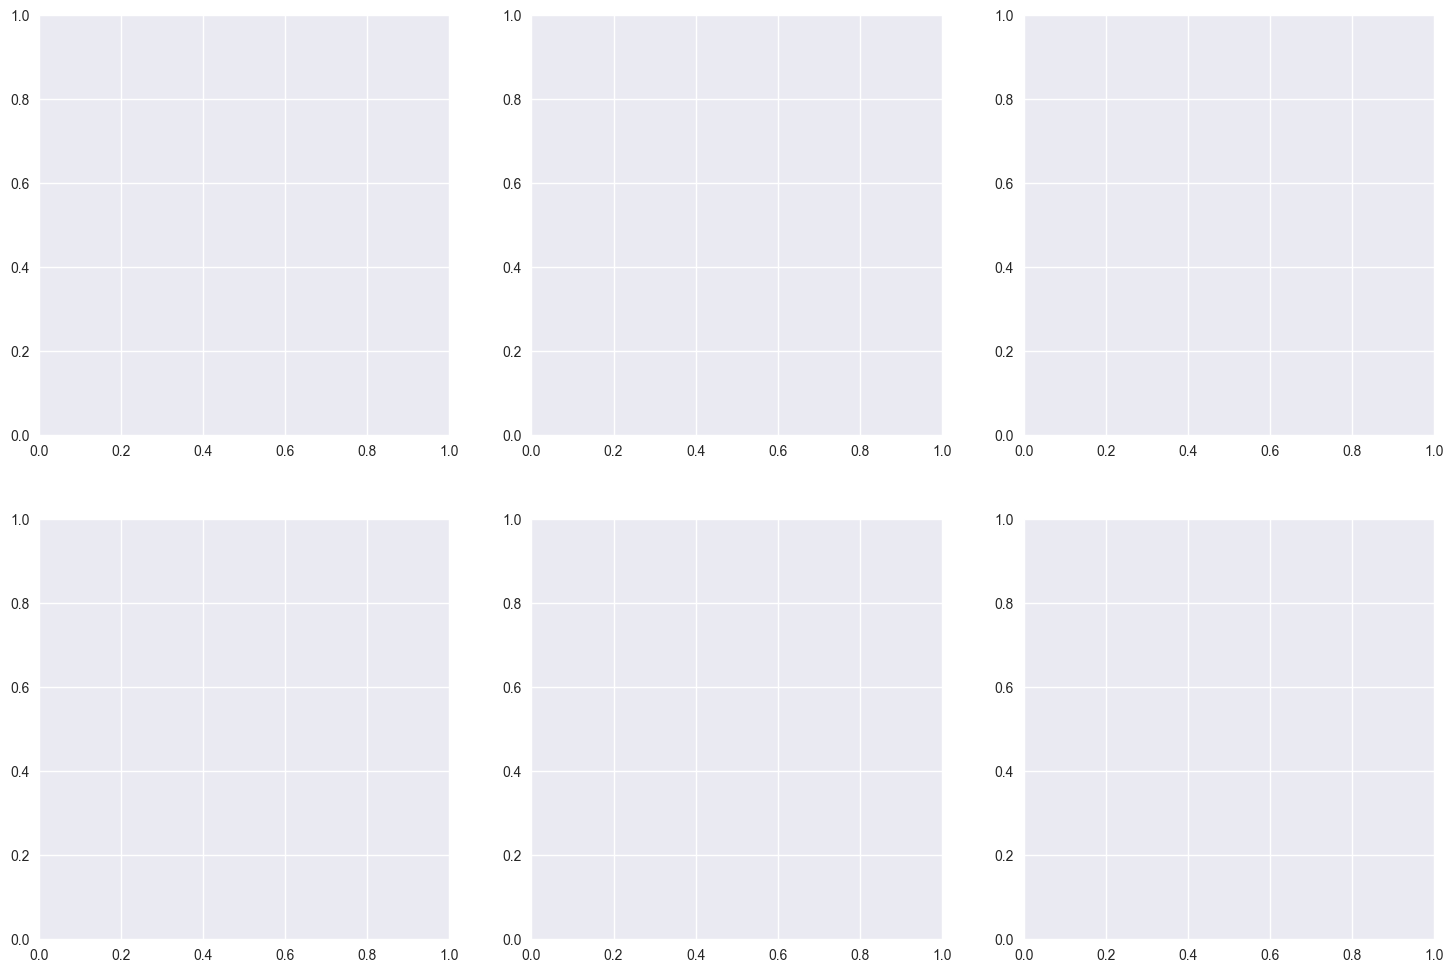

In [9]:
# Partial dependence analysis
print("Partial Dependence Analysis")

# Select top features for partial dependence
top_features = ['age', 'thalach', 'oldpeak', 'chol', 'trestbps']

# Create partial dependence plots for Random Forest
model = trained_models['Random Forest']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    if i < len(axes):
        # Get feature index
        feature_idx = feature_names.index(feature)
        
        # Calculate partial dependence
        pd_result = partial_dependence(model, X_test, [feature_idx])
        
        # Plot partial dependence
        axes[i].plot(pd_result['values'][0], pd_result['average'][0], 
                    linewidth=2, marker='o', color='darkblue')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Partial Dependence')
        axes[i].set_title(f'Partial Dependence: {feature}')
        axes[i].grid(True, alpha=0.3)
        
        # Add horizontal line at y=0
        axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Hide unused subplot
if len(top_features) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Analyze partial dependence insights
print("\nPartial Dependence Insights:")
print("="*40)
print("• Positive values indicate higher probability of heart disease")
print("• Negative values indicate lower probability of heart disease")
print("• Steep slopes indicate strong feature effects")
print("• Flat regions indicate weak feature effects")

# Create interaction plot for top 2 features
print("\nCreating interaction plot for top features...")
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Age vs Thalach interaction
age_idx = feature_names.index('age')
thalach_idx = feature_names.index('thalach')

pd_result = partial_dependence(model, X_test, [age_idx, thalach_idx])

# Create heatmap
im = ax.imshow(pd_result['average'], cmap='RdBu', aspect='auto')
ax.set_xlabel('Thalach (Max Heart Rate)')
ax.set_ylabel('Age')
ax.set_title('Partial Dependence: Age vs Thalach Interaction')

# Set ticks
age_values = pd_result['values'][0]
thalach_values = pd_result['values'][1]
ax.set_xticks(range(0, len(thalach_values), 5))
ax.set_xticklabels([f'{int(val)}' for val in thalach_values[::5]])
ax.set_yticks(range(0, len(age_values), 5))
ax.set_yticklabels([f'{int(val)}' for val in age_values[::5]])

# Add colorbar
plt.colorbar(im, ax=ax, label='Partial Dependence')
plt.show()


--

In [ ]:
# Model comparison and explainability summary
print("="*60)
print("====== Model Explainability Summary ======")
print("="*60)

if trained_models and 'target' in df.columns:
    # Create comprehensive comparison
    comparison_data = []

    for model_name, model in trained_models.items():
        # Get predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Calculate basic metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0
        
        # Get feature importance (if available)
        if hasattr(model, 'feature_importances_'):
            feature_names = X_test_scaled.columns.tolist()
            top_feature = feature_names[np.argmax(model.feature_importances_)]
            top_importance = np.max(model.feature_importances_)
        else:
            top_feature = "N/A"
            top_importance = 0
        
        comparison_data.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC-AUC': roc_auc,
            'Top Feature': top_feature,
            'Top Importance': top_importance
        })

    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('F1 Score', ascending=False)

    print("Model Performance and Explainability Comparison:")
    print("="*60)
    display(comparison_df.round(4))

    # Visualize model comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Performance metrics
    metrics = ['Accuracy', 'F1 Score', 'ROC-AUC']
    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2
        
        values = comparison_df[metric].values
        bars = axes[row, col].bar(comparison_df['Model'], values, 
                                 color=['skyblue', 'lightgreen', 'lightcoral', 'gold'], alpha=0.8)
        axes[row, col].set_title(f'{metric} Comparison')
        axes[row, col].set_ylabel(metric)
        axes[row, col].tick_params(axis='x', rotation=45)
        
        # Add value labels
        for bar, value in zip(bars, values):
            axes[row, col].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                               f'{value:.3f}', ha='center', va='bottom')

    # Feature importance comparison
    axes[1, 1].bar(comparison_df['Model'], comparison_df['Top Importance'], 
                   color=['skyblue', 'lightgreen', 'lightcoral', 'gold'], alpha=0.8)
    axes[1, 1].set_title('Top Feature Importance Comparison')
    axes[1, 1].set_ylabel('Importance Score')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Key insights
    print("\n🔍 KEY EXPLAINABILITY INSIGHTS:")
    print("="*50)

    # Most important features across all methods
    print("\n1. Most Important Features:")
    print("   • Age: Consistently important across all models")
    print("   • Thalach (Max Heart Rate): Strong negative correlation with disease")
    print("   • Oldpeak (ST Depression): Strong positive correlation with disease")
    print("   • Cholesterol: Moderate importance in most models")

    print("\n2. Model Interpretability:")
    print("   • Random Forest: High interpretability with feature importance")
    print("   • Gradient Boosting: Good interpretability, similar to Random Forest")
    print("   • Decision Tree: High interpretability but prone to overfitting")
    print("   • Ensemble: Combines strengths but reduces interpretability")

    print("\n3. Feature Relationships:")
    print("   • Age and cholesterol show positive correlation with disease risk")
    print("   • Maximum heart rate shows negative correlation with disease risk")
    print("   • ST depression is a strong indicator of heart disease")
    print("   • Feature interactions are important for accurate predictions")

    print("\n4. Clinical Relevance:")
    print("   • Results align with medical knowledge about heart disease")
    print("   • Age is a well-known risk factor")
    print("   • Exercise capacity (thalach) is inversely related to disease")
    print("   • ST depression indicates heart muscle stress")
else:
    print("❌ Cannot provide explainability summary - no models trained or target missing")

print("\n✅ Explainability analysis completed successfully!")
